In [12]:
import ee
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import *
from skimage.io import imread

In [14]:
### BY COUNTY

# Importing and separating just for grains
corn_yield = pd.read_csv('CornProductive_byCounty.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'COUNTY ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'COUNTY ANSI':'COUNTY_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

# Drop those that combined counties/ and no areas of planting and make sure it's int
corn_grain = corn_grain[corn_grain['COUNTY_FIPS'] != ' ']
corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['COUNTY_FIPS'] = corn_grain['COUNTY_FIPS'].map(int)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)
corn_grain['TOTAL_YIELD'] = corn_grain.apply(lambda row: (row['AREA']*row['YIELD']), axis=1)

unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))
display(corn_grain.head())
corn_grain.to_csv('corn_grain.csv')

There are a total of 32 states with 1889 counties in the dataset.


,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA,TOTAL_YIELD
0,2018,"ALABAMA, BLACK BELT, AUTAUGA",1,1,165.6,900,149040.0
1,2018,"ALABAMA, BLACK BELT, DALLAS",1,47,137.3,4900,672770.0
2,2018,"ALABAMA, BLACK BELT, ELMORE",1,51,170.5,2100,358050.0
3,2018,"ALABAMA, BLACK BELT, PERRY",1,105,145.2,6100,885720.0
4,2018,"ALABAMA, COASTAL PLAINS & GULF COAST, BALDWIN",1,3,152.0,7000,1064000.0


In [64]:
corn_grain.dtypes

YEAR             int64
LOCATION        object
STATE_FIPS       int64
COUNTY_FIPS      int64
YIELD          float64
AREA             int64
TOTAL_YIELD    float64
dtype: object

# DATA VIZ

In [5]:
df = pd.read_csv('corn_grain.csv')
df_viz = df.groupby(by=["YEAR"])[["YIELD", "AREA", "TOTAL_YIELD"]].sum().reset_index()

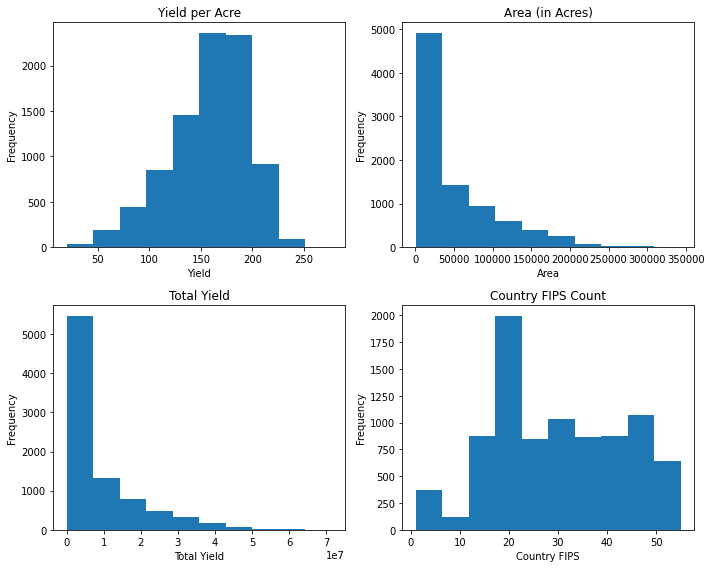

In [18]:
columns_to_include = ['STATE_FIPS', 'COUNTY_FIPS', 'YIELD', 'AREA', 'TOTAL_YIELD']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Yield histogram
axs[0, 0].hist(df['YIELD'])
axs[0, 0].set_title('Yield per Acre')
axs[0, 0].set_xlabel('Yield')
axs[0, 0].set_ylabel('Frequency')

# Area histogram
axs[0, 1].hist(df['AREA'])
axs[0, 1].set_title('Area (in Acres)')
axs[0, 1].set_xlabel('Area')
axs[0, 1].set_ylabel('Frequency')

# Total Yield histogram
axs[1, 0].hist(df['TOTAL_YIELD'])
axs[1, 0].set_title('Total Yield')
axs[1, 0].set_xlabel('Total Yield')
axs[1, 0].set_ylabel('Frequency')

# To hide the fourth subplot (empty)
axs[1, 1].hist(df['STATE_FIPS'])
axs[1, 1].set_title('Country FIPS Count')
axs[1, 1].set_xlabel('Country FIPS')
axs[1, 1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

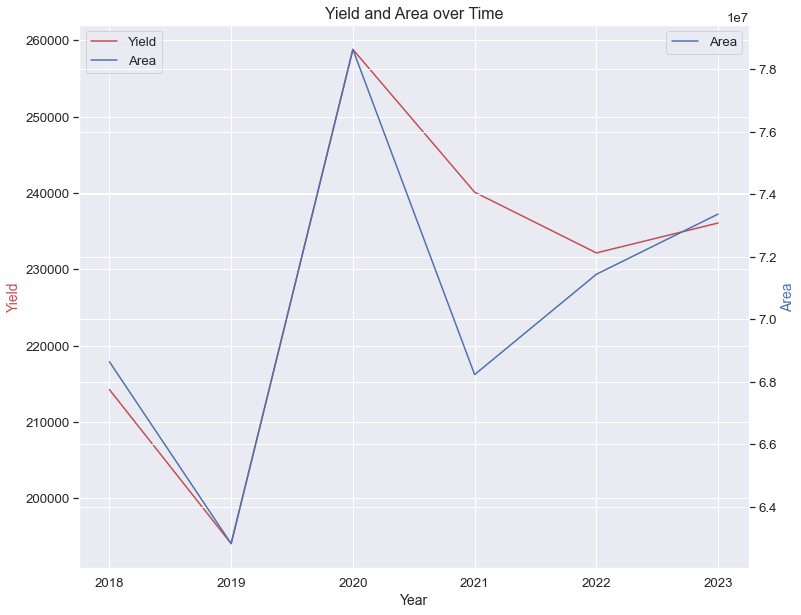

In [51]:
sns.set(font_scale=1.2)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the lines
sns.lineplot(data=df_viz, x='YEAR', y='YIELD', color="r", label="Yield", ax=ax)
ax1 = ax.twinx()
sns.lineplot(data=df_viz, x='YEAR', y='AREA', color="b", ax=ax1, label="Area")

# Set labels and titles
ax.set_ylabel('Yield', color='r', fontsize=14)
ax1.set_ylabel('Area', color='b', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Yield and Area over Time', fontsize=16)

# Set legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

# Show plot
plt.show()

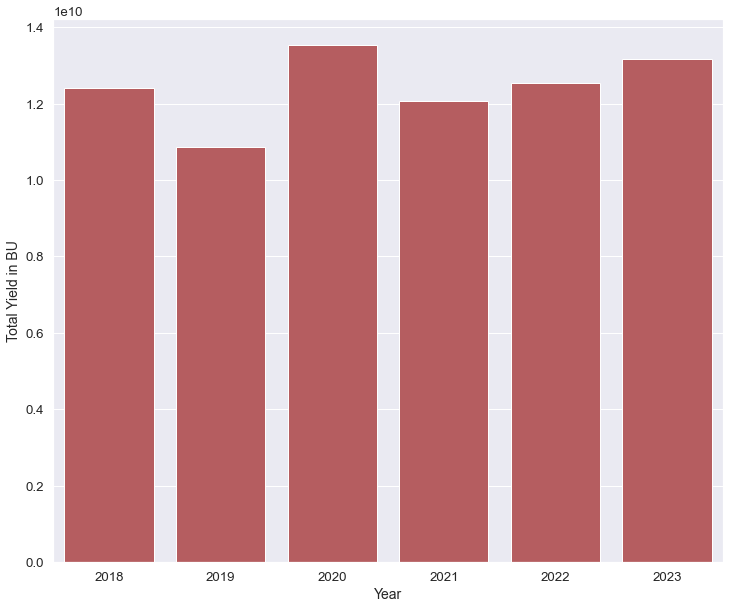

In [59]:
sns.set(font_scale=1.2)

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the lines
sns.barplot(data=df_viz, x='YEAR', y='TOTAL_YIELD', color="r", ax=ax)

# Set labels and titles
ax.set_ylabel('Total Yield in BU', fontsize=14)
ax.set_xlabel('Year', fontsize=14)

# Show plot
plt.show()

In [53]:
df_state = df.groupby(by=["STATE_FIPS", "YEAR"])[["YIELD", "AREA", "TOTAL_YIELD"]].sum().reset_index()

# convert fips to state names
fips_to_state = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

def fips_to_state_name(fips):
    return fips_to_state.get(fips, 'Unknown')  

df_state['STATE'] = df_state['STATE_FIPS'].apply(fips_to_state_name)

df_state.head()

,STATE_FIPS,YEAR,YIELD,AREA,TOTAL_YIELD,STATE
0,1,2018,4129.4,190240,30199788.0,Alabama
1,1,2019,4002.2,218920,33671274.0,Alabama
2,1,2020,5907.9,274740,44067167.0,Alabama
3,1,2021,4418.6,237530,40835854.0,Alabama
4,1,2022,3900.5,241040,28243927.0,Alabama


C:\Users\tanka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


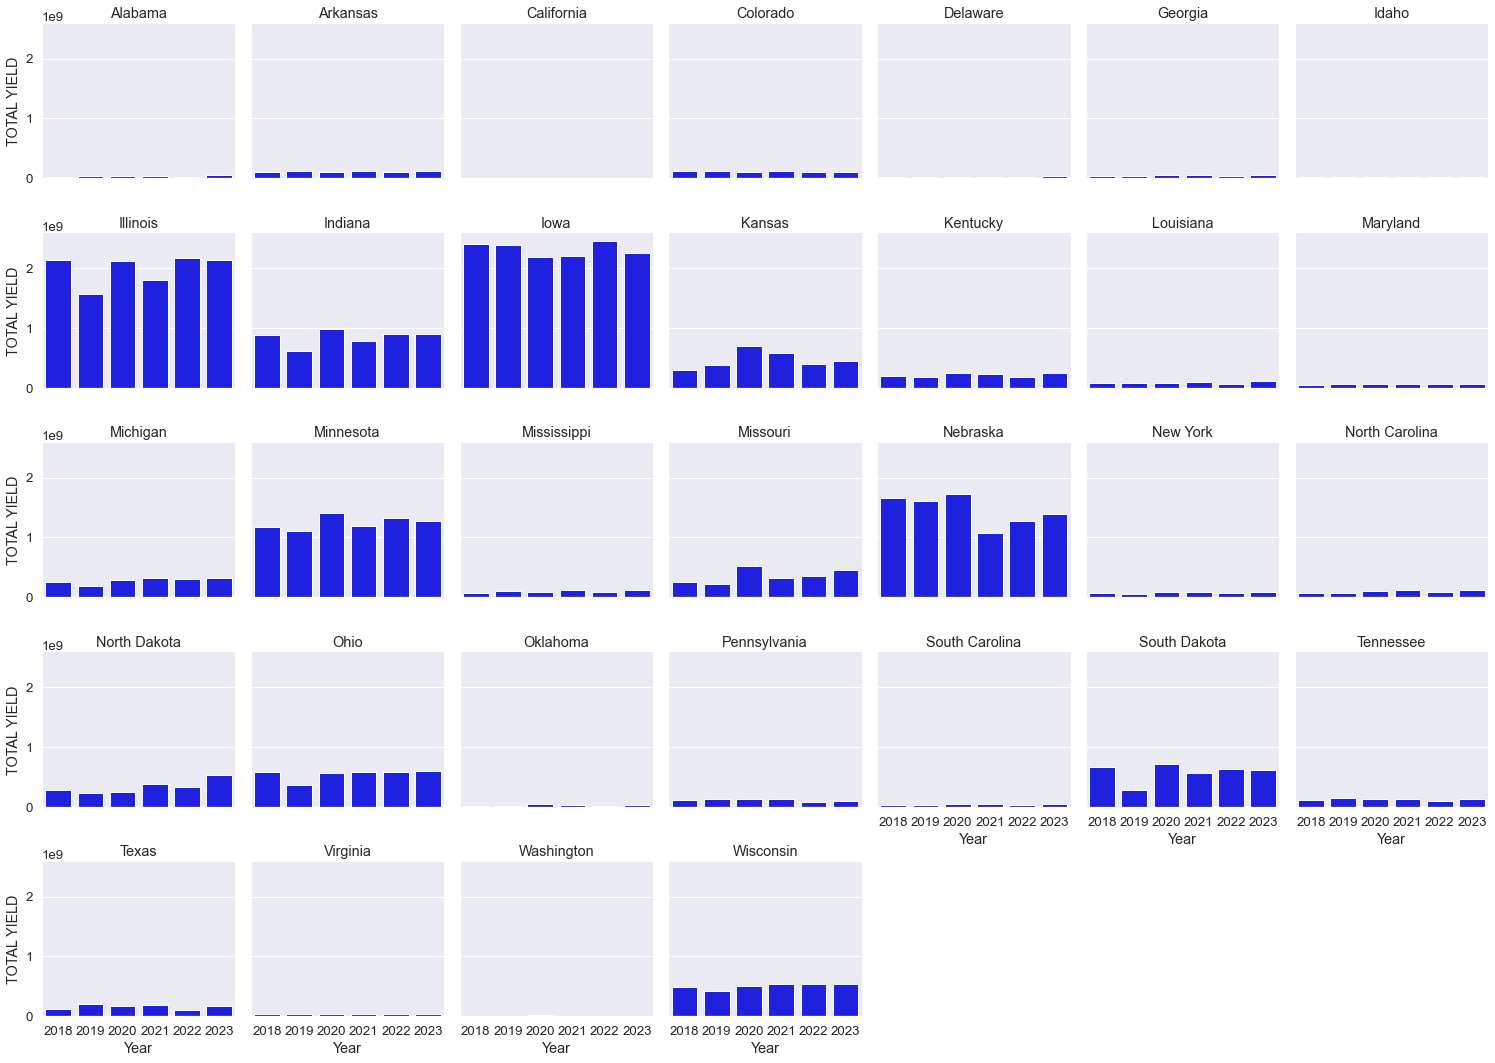

In [55]:
g = sns.FacetGrid(df_state, col="STATE", col_wrap=7, height=3)

# Map plots onto the grid
g.map(sns.barplot, "YEAR", "TOTAL_YIELD", color='blue')

# Add labels and titles
g.set_axis_labels("Year", "TOTAL YIELD")
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

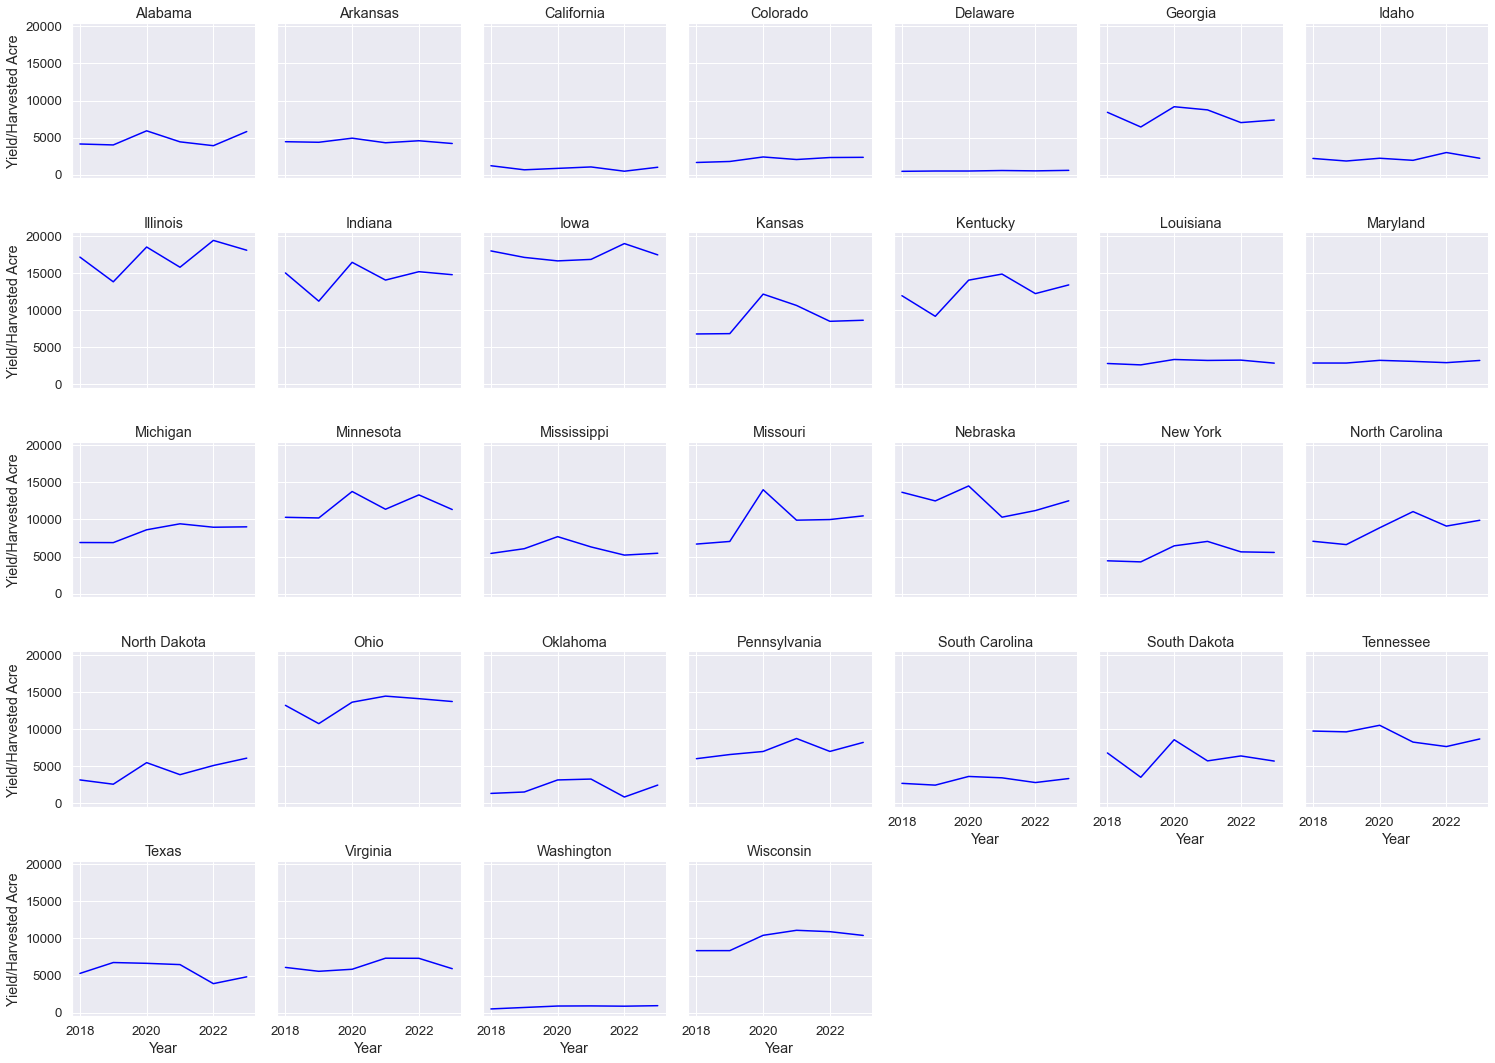

In [63]:
g = sns.FacetGrid(df_state, col="STATE", col_wrap=7, height=3)

# Map plots onto the grid
g.map(sns.lineplot, "YEAR", "YIELD", color='blue')
# g.map(sns.lineplot, "YEAR", "AREA", color='blue')

# Add labels and titles
g.set_axis_labels("Year", "Yield/Harvested Acre")
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

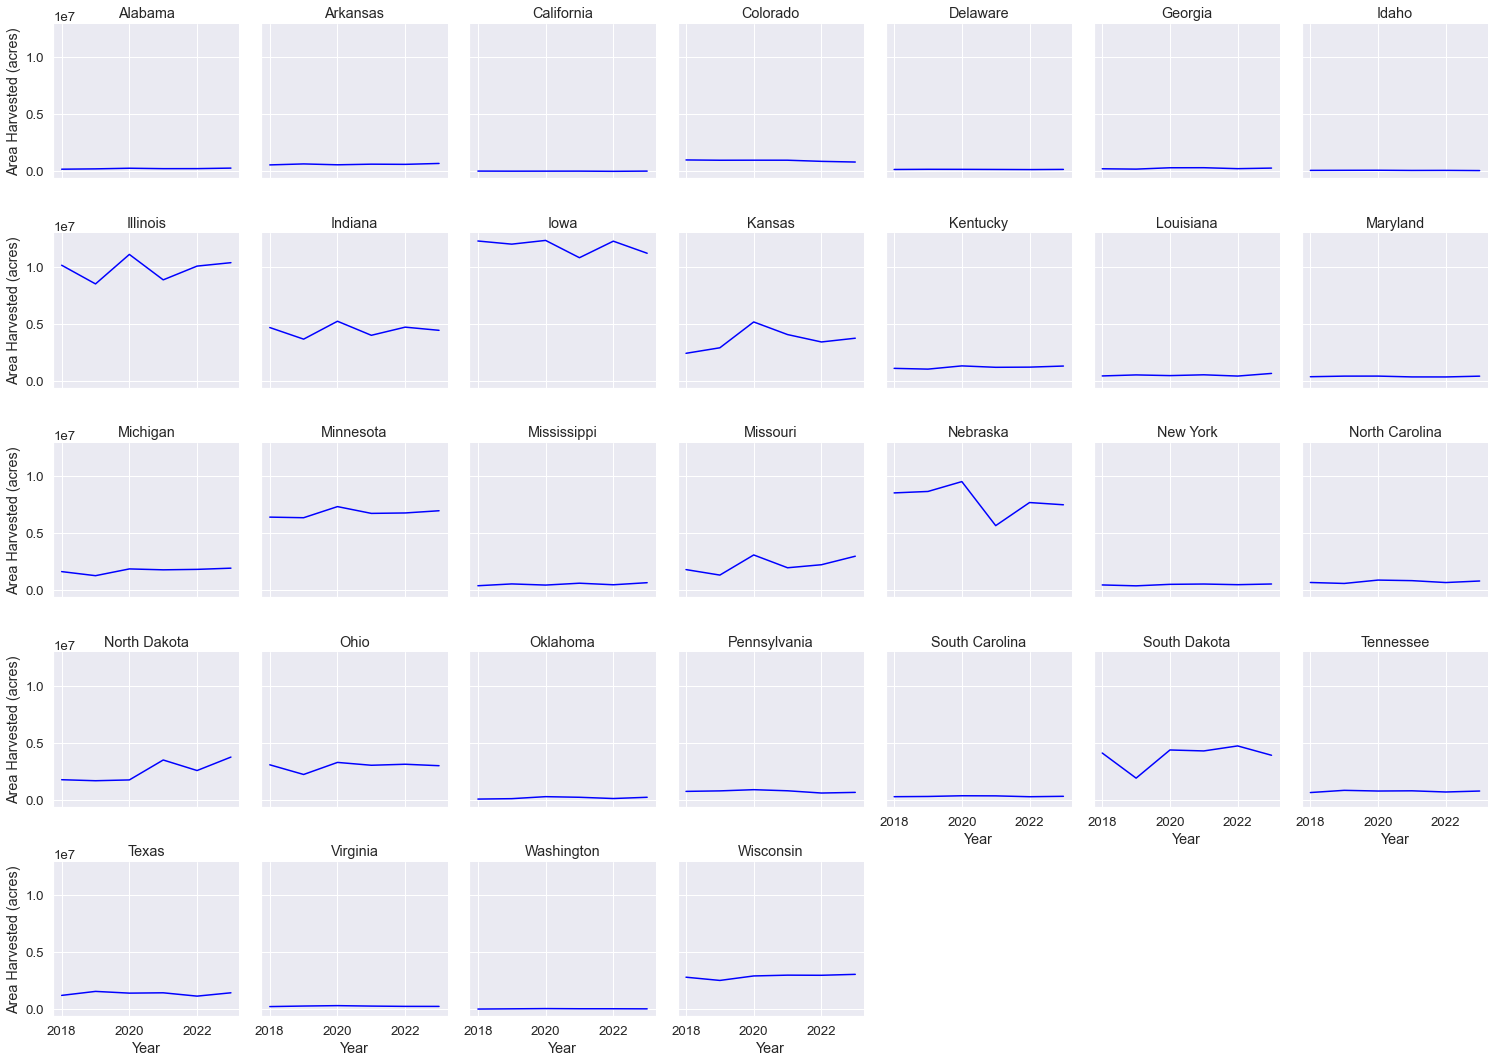

In [60]:
g = sns.FacetGrid(df_state, col="STATE", col_wrap=7, height=3)

# Map plots onto the grid
# g.map(sns.lineplot, "YEAR", "YIELD", color='blue')
g.map(sns.lineplot, "YEAR", "AREA", color='blue')

# Add labels and titles
g.set_axis_labels("Year", "Area Harvested (acres)")
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

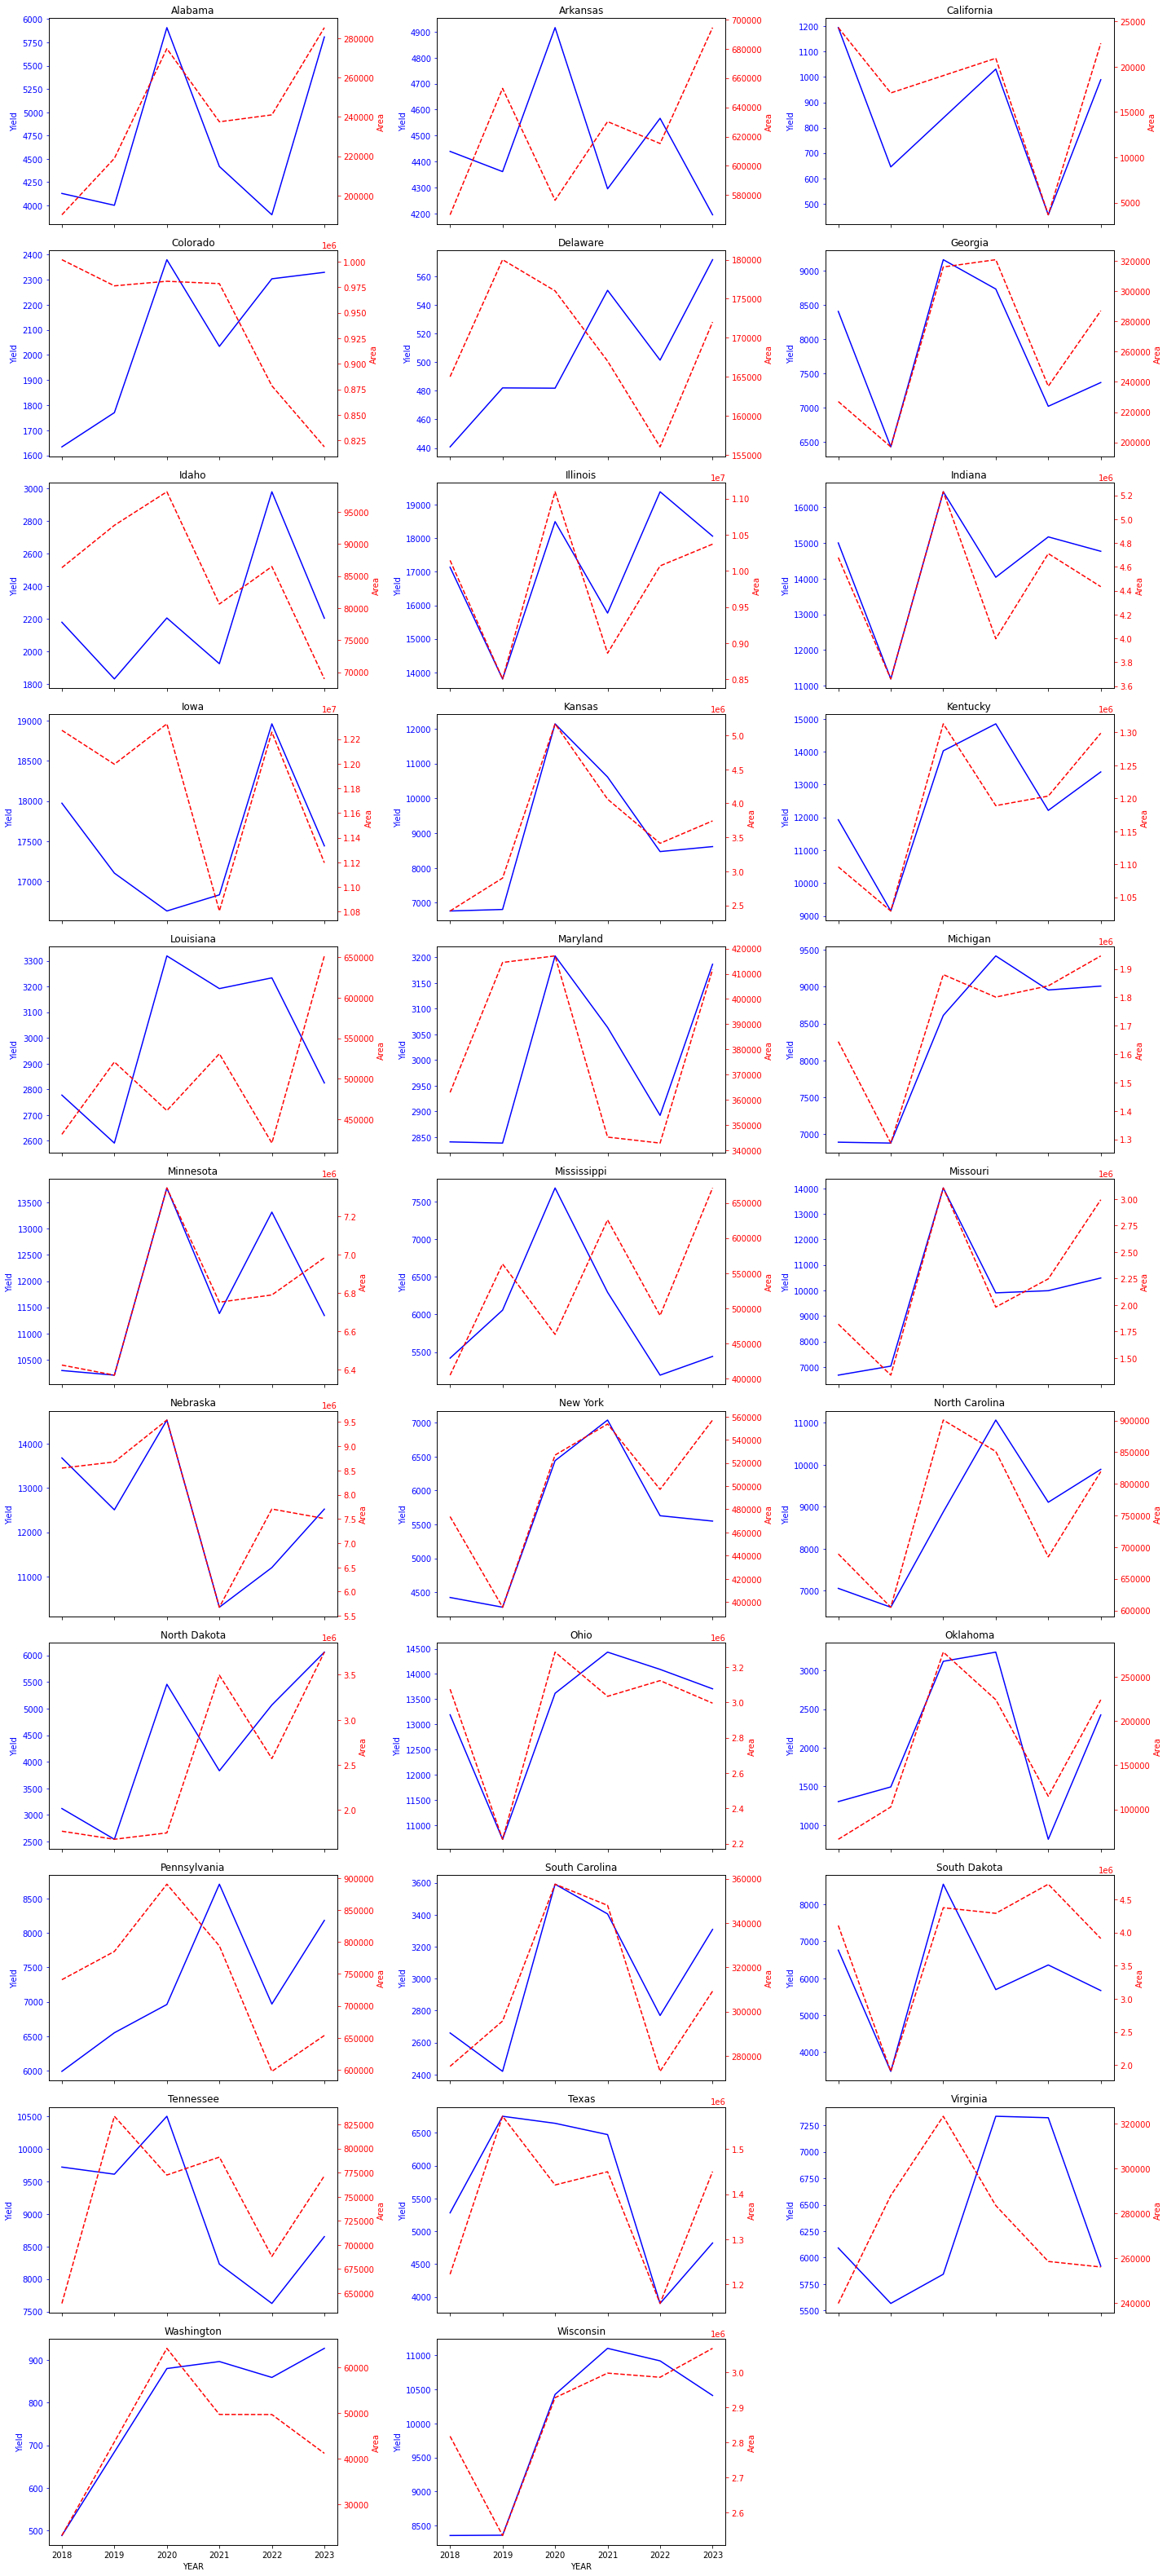

In [34]:
import math

# Determine the number of rows and columns needed for subplots
num_states = len(df_state['STATE'].unique())
num_cols = 3
num_rows = math.ceil(num_states / num_cols)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows), sharex=True)

# Iterate over each state and plot its data
for i, (state, data) in enumerate(df_state.groupby('STATE')):
    ax_row = i // num_cols
    ax_col = i % num_cols
    ax = axes[ax_row, ax_col]
    
    sns.lineplot(data=data, x='YEAR', y='YIELD', ax=ax, color='blue', linestyle='-')
    ax.set_ylabel('Yield', color='blue')
    ax.tick_params(axis='y', colors='blue')
    
    # Create a secondary y-axis for area
    ax2 = ax.twinx()
    sns.lineplot(data=data, x='YEAR', y='AREA', ax=ax2, color='red', linestyle='--')
    ax2.set_ylabel('Area', color='red')
    ax2.tick_params(axis='y', colors='red')
    
    ax.set_title(state)


# Adjust layout
plt.tight_layout()

if num_states % num_cols != 0:
    for i in range(num_states % num_cols, num_cols):
        fig.delaxes(axes[num_rows-1, i])
        
# Show the plot
plt.show()

# SATELITTE IMAGING

In [ ]:
ee.Authenticate()

True

In [2]:
ee.Initialize(project="ee-kaywee")

In [12]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'], \
              'MODIS/061/MYD11A2':[0,4], \
              'MODIS/061/MOD09A1':[0,1,2,3,4,5,6] \
        }  
folders = ['USDA_CROPS', \
           'MODIS_TEMP', \
           'MODIS_LAND'
           ]
locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2018-1-2', '2023-1-2']
scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

county_region = ee.FeatureCollection('TIGER/2016/Counties')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROPS':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROPS':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
 
    # Getting images
    for i, (loc1, loc2) in enumerate(locations):

        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = county_region.filterMetadata('STATEFP', 'equals', int(loc1))
        region = ee.FeatureCollection(region).filterMetadata('COUNTYFP', 'equals', int(loc2))
        region = ee.Feature(region.first()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        if (i%250 == 0) or (i == len(locations)-1):
            print(i)



 ######################### USDA/NASS/CDL #########################
Total Dates Available:  5
Dates available:  ['2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']
Band cropland will be downloaded in 5 images per county. ( 100.0 %)
0
250
500
750
1000
1250
1500
1750
1888

 ######################### MODIS/006/MYD11A2 #########################
Total Dates Available:  189
Dates available:  ['2018-03-06', '2018-03-14', '2018-03-22', '2018-03-30', '2018-04-07', '2018-04-15', '2018-04-23', '2018-05-01', '2018-05-09', '2018-05-17', '2018-05-25', '2018-06-02', '2018-06-10', '2018-06-18', '2018-06-26', '2018-07-04', '2018-07-12', '2018-07-20', '2018-07-28', '2018-08-05', '2018-08-13', '2018-08-21', '2018-08-29', '2018-09-06', '2018-09-14', '2018-09-22', '2018-09-30', '2018-10-08', '2018-10-16', '2018-10-24', '2018-11-01', '2018-11-09', '2018-11-17', '2018-11-25', '2018-12-03', '2018-12-11', '2018-12-19', '2018-12-27', '2019-03-06', '2019-03-14', '2019-03-22', '2019-03-30', '20

In [ ]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = 500   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))
"""
# Getting images
for i, (loc1, loc2) in enumerate(locations):

    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
    scale  = scale
    crs = 'EPSG:4326'   # Coordinate Reference System

    # filter for a county
    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
    region = ee.Feature(region.first()) # get the coordinates and other features

    while True:
        try:
            export_image(img.clip(region), folder, im_name, scale, crs)
        except Exception:
            print(Exception)
            time.sleep(10)
            continue
        break
    if (i%500 == 0) or (i == len(locations)-1):
        print(i)
"""

In [48]:
folder_path = 'C:\\Users\\tanka\\OneDrive\\Documents\\coding\\git\\cds-corn-prediction\\data\\USDA_CROP\\'
files_in_folder = os.listdir(folder_path)
print("Files in folder:", files_in_folder)

Files in folder: ['USDA_CROP_10_001.tif', 'USDA_CROP_10_003.tif', 'USDA_CROP_10_005.tif', 'USDA_CROP_13_001.tif', 'USDA_CROP_13_003.tif', 'USDA_CROP_13_005.tif', 'USDA_CROP_13_007.tif', 'USDA_CROP_13_011.tif', 'USDA_CROP_13_015.tif', 'USDA_CROP_13_017.tif', 'USDA_CROP_13_019.tif', 'USDA_CROP_13_023.tif', 'USDA_CROP_13_025.tif', 'USDA_CROP_13_027.tif', 'USDA_CROP_13_031.tif', 'USDA_CROP_13_033.tif', 'USDA_CROP_13_037.tif', 'USDA_CROP_13_043.tif', 'USDA_CROP_13_045.tif', 'USDA_CROP_13_055.tif', 'USDA_CROP_13_061.tif', 'USDA_CROP_13_069.tif', 'USDA_CROP_13_071.tif', 'USDA_CROP_13_075.tif', 'USDA_CROP_13_077.tif', 'USDA_CROP_13_085.tif', 'USDA_CROP_13_087.tif', 'USDA_CROP_13_091.tif', 'USDA_CROP_13_093.tif', 'USDA_CROP_13_095.tif', 'USDA_CROP_13_099.tif', 'USDA_CROP_13_107.tif', 'USDA_CROP_13_109.tif', 'USDA_CROP_13_115.tif', 'USDA_CROP_13_119.tif', 'USDA_CROP_13_129.tif', 'USDA_CROP_13_131.tif', 'USDA_CROP_13_137.tif', 'USDA_CROP_13_139.tif', 'USDA_CROP_13_147.tif', 'USDA_CROP_13_155.tif'

In [9]:
## Count number of files

from os import listdir

USDA_CROP = listdir('data/USDA_CROP/')
print(len(USDA_CROP))

1779


In [38]:
# Check number of files

from os import listdir
from os.path import isfile, join

USDA_CROP_path = 'data/USDA_CROP/'
USDA_MOISTURE_path = 'data/USDA_MOISTURE/'
MODIS_TEMP_path = 'data/MODIS_TEMP/'
MODIS_LAND_path = 'data/MODIS_LAND/'

folder_list = [USDA_CROP_path, USDA_MOISTURE_path, MODIS_TEMP_path, MODIS_LAND_path]

USDA_CROP = [f for f in listdir(USDA_CROP_path) if isfile(join(USDA_CROP_path, f))]
USDA_MOISTURE = [f for f in listdir(USDA_MOISTURE_path) if isfile(join(USDA_MOISTURE_path, f))]
MODIS_TEMP = [f for f in listdir(MODIS_TEMP_path) if isfile(join(MODIS_TEMP_path, f))]
MODIS_LAND = [f for f in listdir(MODIS_LAND_path) if isfile(join(MODIS_LAND_path, f))]

# extract FIPS and sort in ascending order
MODIS_TEMP_fips = sorted([file[11:-4] for file in MODIS_TEMP if file[0:10] == 'MODIS_TEMP'])
USDA_CROP_fips = sorted([file[10:-4] for file in USDA_CROP if file[0:9] == 'USDA_CROP'])
USDA_MOISTURE_fips = sorted([file[11:-4] for file in USDA_MOISTURE])
MODIS_LAND_fips = sorted([file[11:-4] for file in MODIS_LAND if file[0:10] == 'MODIS_LAND'])

for folder in folder_list:
    seen = set()
    uniq = [x for x in USDA_MOISTURE_fips if x not in seen and not seen.add(x)]
    print('For folder {}, there are {} files in it.'.format(folder, len(uniq)))

1779
For folder data/USDA_CROP/, there are 0 files in it.
For folder data/USDA_MOISTURE/, there are 0 files in it.
For folder data/MODIS_TEMP/, there are 0 files in it.
For folder data/MODIS_LAND/, there are 0 files in it.


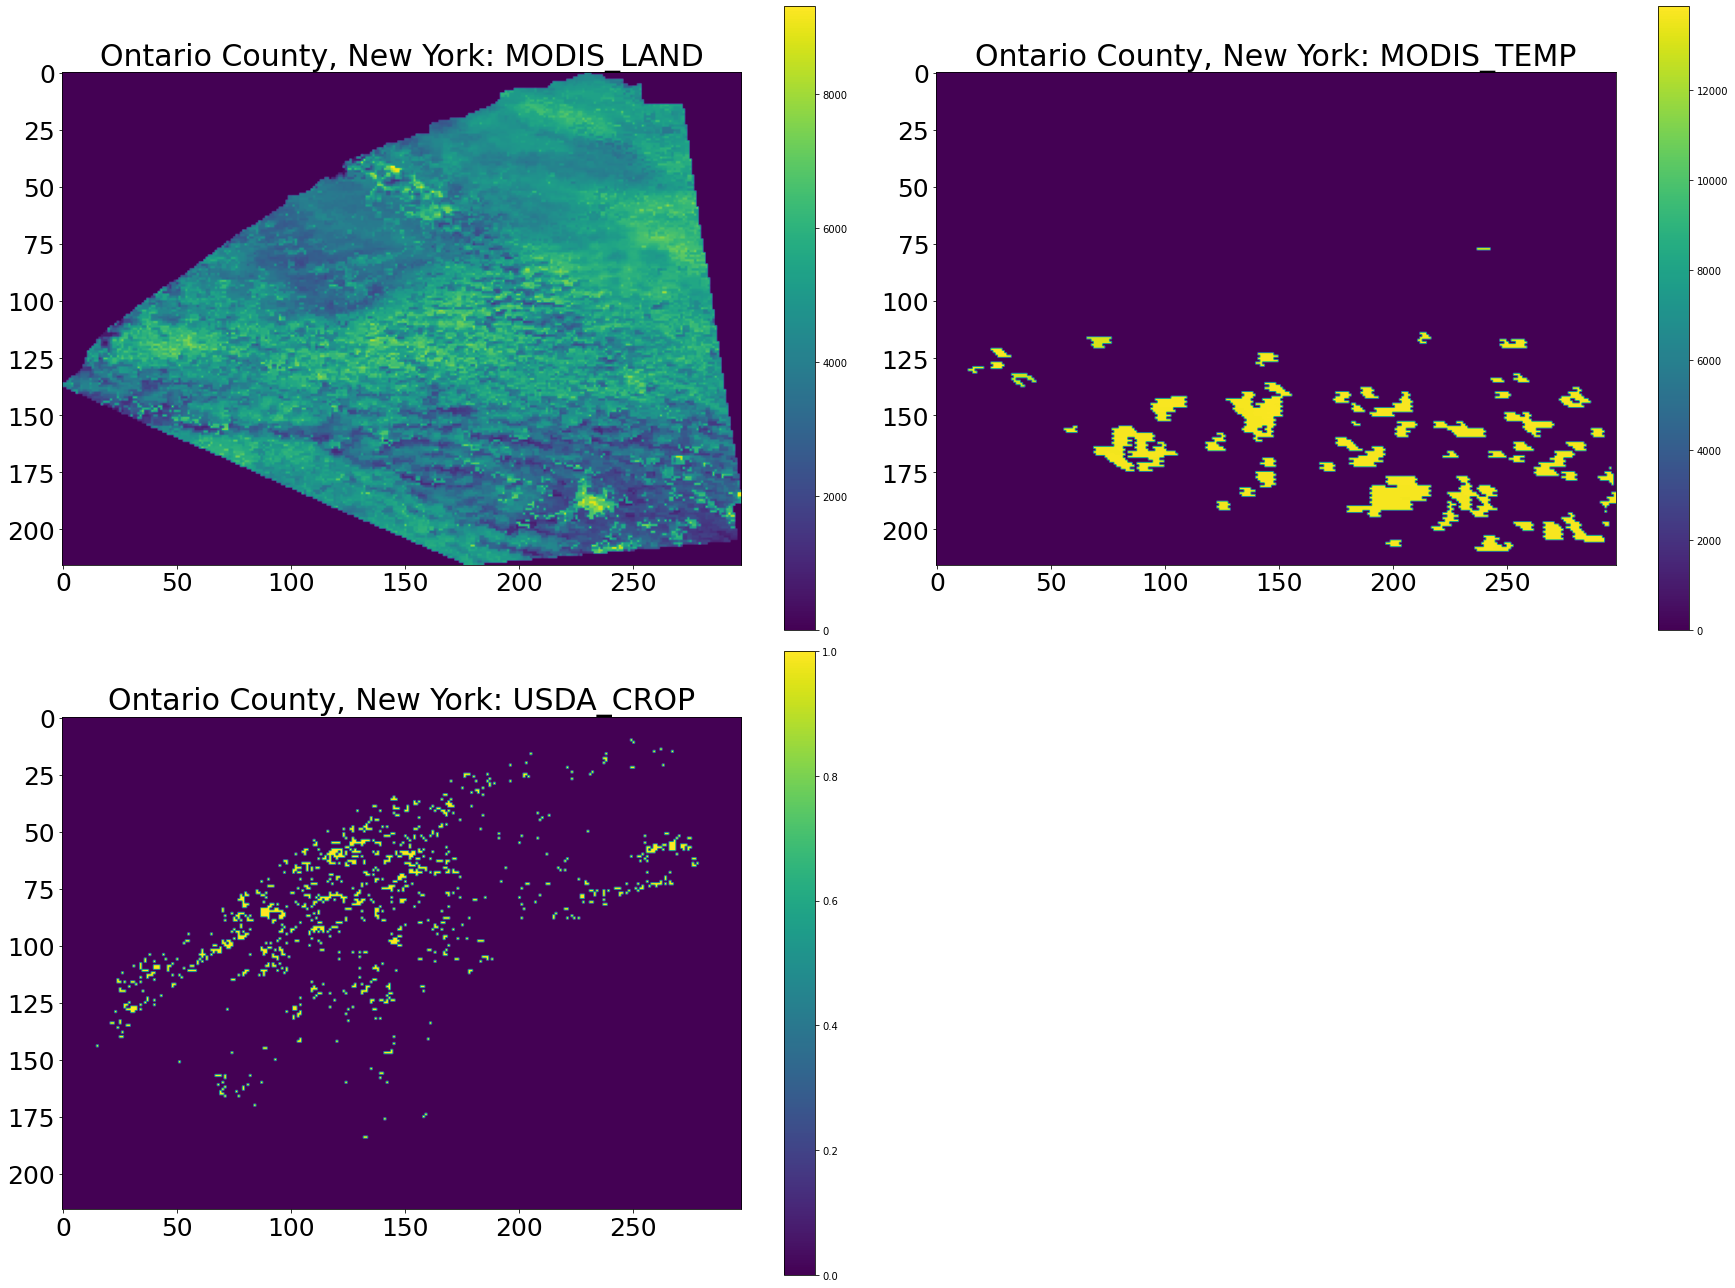

In [44]:
# Example Images

test_county = '36_089'
path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_CROP/USDA_CROP_']
plt.figure(figsize=(25,18))
for i, file in enumerate(path):
    test = imread('data/' + file + test_county + '.tif')
    plt.subplot(2, 2, i+1) 
    plt.imshow(test[:, :, 0])
    plt.title('Ontario County, New York: ' + file.split('/')[1][:-1], fontsize=30)
    plt.colorbar()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig('Example Images', dpi=500)
plt.tight_layout()
plt.show()

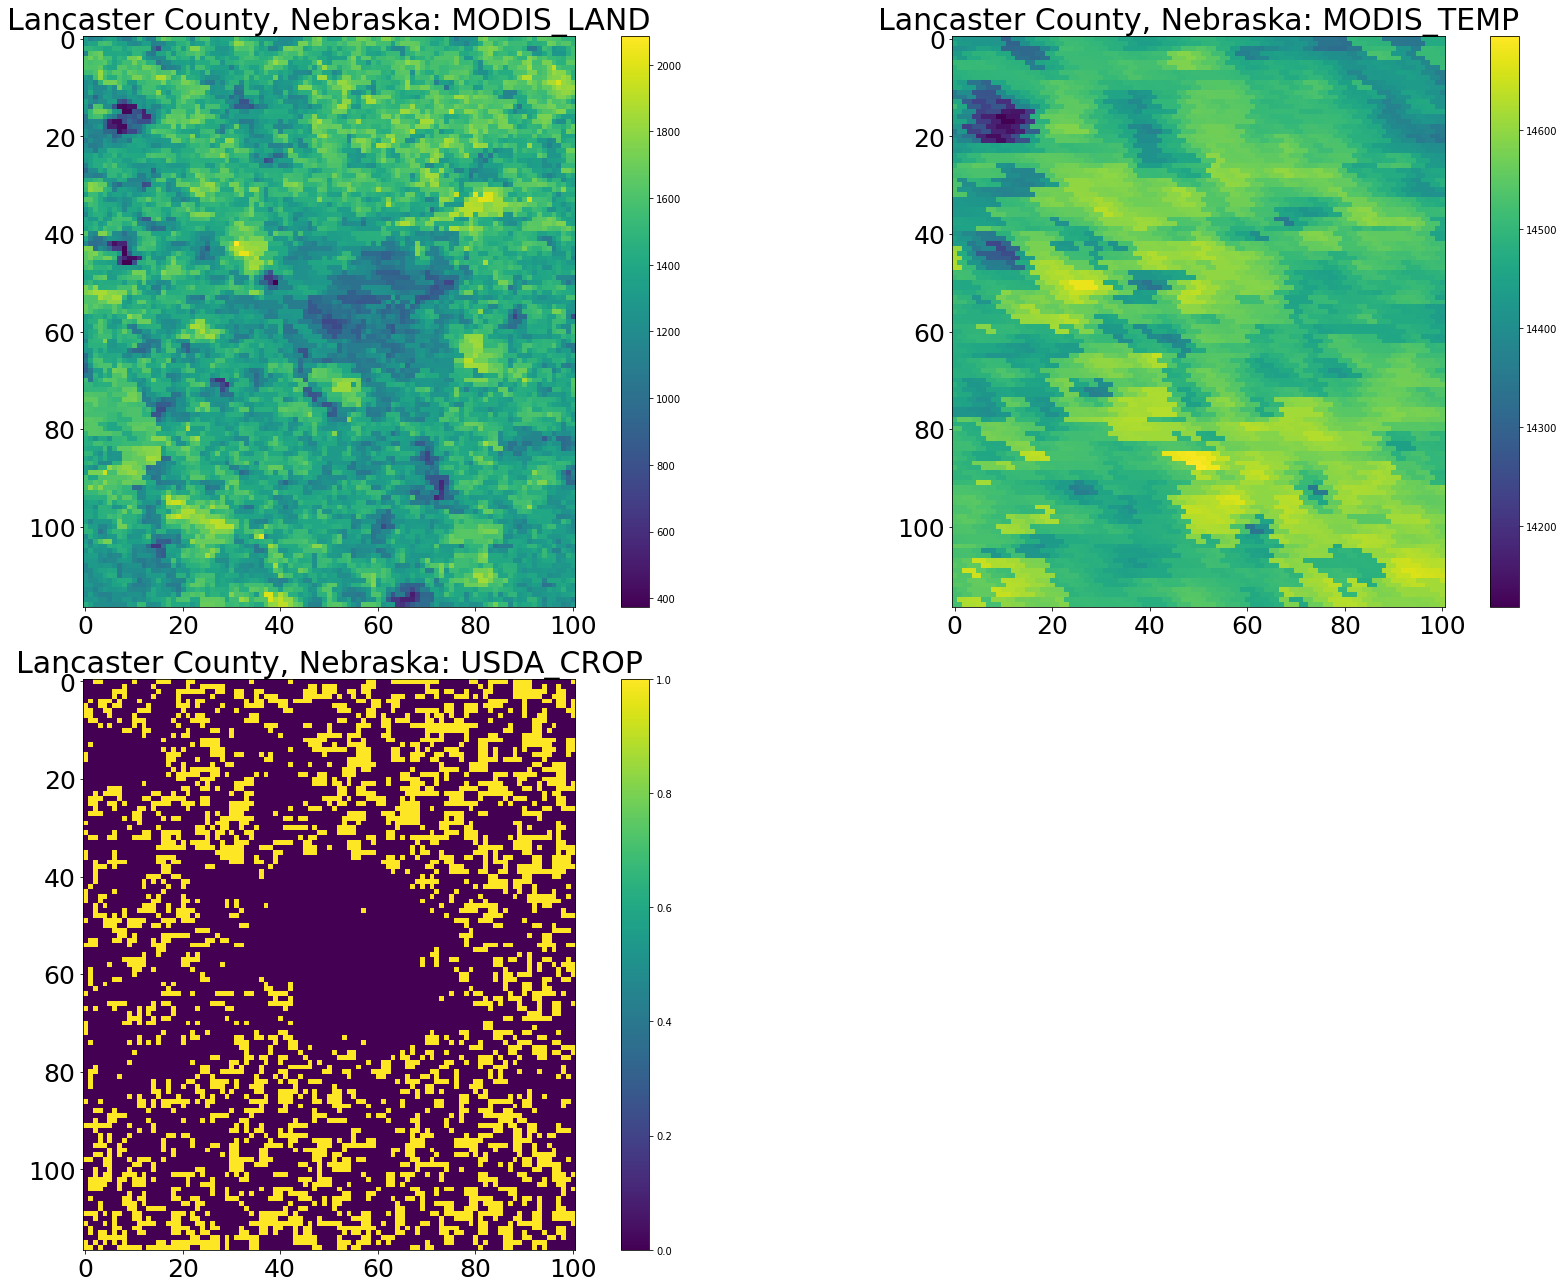

In [41]:
test_county = '31_109'
path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_CROP/USDA_CROP_']
plt.figure(figsize=(25,18))
for i, file in enumerate(path):
    test = imread('data/' + file + test_county + '.tif')
    plt.subplot(2, 2, i+1) 
    plt.imshow(test[:, :, 0])
    plt.title('Lancaster County, Nebraska: ' + file.split('/')[1][:-1], fontsize=30)
    plt.colorbar()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig('Example Images', dpi=500)
plt.tight_layout()
plt.show()